## Загрузка библиотек

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
import os

import sklearn
import sklearn.model_selection
import sklearn.metrics
from sklearn.neural_network import MLPClassifier


## Загрузка датасета

In [106]:
DATASET_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'healthcare-dataset-stroke-data.csv'))
data = pd.read_csv(DATASET_PATH)
data.columns = data.columns.str.strip()

## Подготовка датасета(из ML1)

In [107]:
data['smoking_status'].replace({'Unknown': None}, inplace=True)

data['bmi'].fillna(data['bmi'].median(), inplace=True)
probabilities = data['smoking_status'].value_counts(normalize=True)
missing = data['smoking_status'].isnull()
data.loc[missing, 'smoking_status'] = np.random.choice(probabilities.index, size=len(data[missing]), p=probabilities.values)

data.drop('id', axis=1, inplace=True)

data['gender'] = np.where(data['gender'] == 'Male', 1, 0)
data['ever_married'] = np.where(data['ever_married'] == 'Yes', 1, 0)
data['Residence_type'] = np.where(data['Residence_type'] == 'Urban', 1, 0)

data = pd.get_dummies(data)

normalizedData = (data - data.mean(axis = 0)) / data.std(axis = 0)


## Разбиваем данные на обучающую и тестовую выборки

In [108]:
from sklearn.model_selection import train_test_split
x = normalizedData.drop(['stroke'], axis=1)
y = data['stroke']
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.25, random_state=43)

## Обучаем классификатор

In [109]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          random_state = 42)


In [110]:
%%time
mlp_model.fit(x_train, y_train)

Wall time: 2.05 s


MLPClassifier(activation='logistic', random_state=42, solver='lbfgs')

## Проверяем качество классификатора

In [111]:
y_train_pred = mlp_model.predict(x_train)
y_test_pred = mlp_model.predict(x_test)

In [112]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_train_pred)


1.0

In [113]:
accuracy_score(y_test, y_test_pred)

0.9147104851330203

## Подбор _гипер_параметров

Подберем оптимальное значение параметра регуляризации alpha

In [114]:
alpha_arr = np.logspace(-3, 2, 16)
test_err = []
train_err = []

for alpha in alpha_arr:
    model = MLPClassifier(
        alpha=alpha,
        hidden_layer_sizes=(100,),
        solver='lbfgs',
        activation ='logistic',
        max_iter=1000,
        random_state = 42
    )
    model.fit(x_train, y_train)

    y_train_prediction = model.predict(x_train)
    y_test_prediction = model.predict(x_test)

    test_err.append(np.mean(y_test != y_test_prediction))
    train_err.append(np.mean(y_train != y_train_prediction))

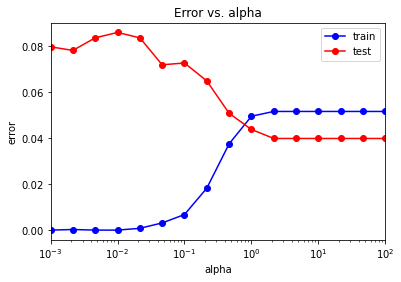

In [115]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

Минимальное значение ошибки:

In [116]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.0 0.03990610328638498


Оптимальное значение alpha:

In [117]:
min_test_err = np.min(test_err)
alpha_optimal = alpha_arr[test_err == min_test_err][0]
print('Optimal alpha: {}'.format(alpha_optimal))

Optimal alpha: 2.154434690031882


## Подбор числа нейронов

In [118]:
neuron_count_arr = np.linspace(1, 800, 24).astype(int)
test_err = []
train_err = []

for neuron_count in neuron_count_arr:
    model = MLPClassifier(
        alpha=alpha_optimal,
        hidden_layer_sizes=(neuron_count,),
        solver='lbfgs',
        activation ='logistic',
        max_iter=1000,
        random_state = 42
    )
    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    test_err.append(np.mean(y_test != y_test_pred))
    train_err.append(np.mean(y_train != y_train_pred))

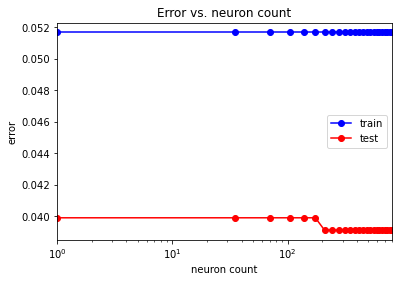

In [119]:
plt.semilogx(neuron_count_arr, train_err, 'b-o', label = 'train')
plt.semilogx(neuron_count_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(neuron_count_arr), np.max(neuron_count_arr)])
plt.title('Error vs. neuron count')
plt.xlabel('neuron count')
plt.ylabel('error')
plt.legend()

## Классификатор при найденном оптимальном значении alpha:

In [120]:
mlp_model = MLPClassifier(alpha = alpha_optimal, hidden_layer_sizes = (100,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(x_train, y_train)

y_train_pred = mlp_model.predict(x_train)
y_test_pred = mlp_model.predict(x_test)
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

0.9483298538622129
0.960093896713615


## Матрица рассогласования:

<function matplotlib.pyplot.show(close=None, block=None)>

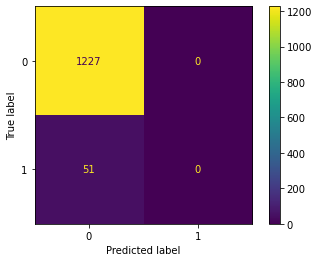

In [121]:
confusion_maxtrix = sklearn.metrics.confusion_matrix(y_test, y_test_prediction, labels=model.classes_)
confusion_maxtrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_maxtrix, display_labels=model.classes_)
confusion_maxtrix_display.plot()
plt.show

## Вывод

При подборе оптимальных значений гиперпараметров удалось достичь большого изменения точности, примерно на 4% выше.

Исходя из этого, можно сказать, что у выбранного датасета есть явная зависимость точности от оптимизируемых гиперпараметров.